# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 topics most highly correlated with Consumption growth (out of 200 topics estimated on articles published before 2008 using all sources). I forecast Consumption growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 topics (<=2007, 200 topics, all sources).
- **Forecast Target:** Consumption growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Hard+Surveys Factors:** 1 to 2
  - **Number of Text Factors:** 1
  - **Factor Order:** 1 to 3

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'Consumption'                     # quarterly variable being forecasted
additional_factors = 'HardSurveys+Text'   # switch to separate factors scenario
start = '1991-04'
text_type = "topics"
estimation_period = "2007"
num_topics = "200"
source = "all"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
       
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of HardSurveys factors (1 or 2) and factor order values from 1 to 3
for num_factors in range(1, 3):  # 1 or 2 HardSurveys factors
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'HardSurveys': num_factors, 'Text': 1}
        factor_orders = {'HardSurveys': order, 'Text': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with HardSurveys factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = f"HS_{num_factors}_{order}"
        file_name = f"forecasts_{q_var}_{factors_str}.csv"
        
        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11753
EM converged at iteration 66, llf=-11506, convergence criterion=9.9614e-07 < tolerance=1e-06
EM start iterations, llf=-11765
EM converged at iteration 66, llf=-11519, convergence criterion=9.956e-07 < tolerance=1e-06
EM start iterations, llf=-11817
EM converged at iteration 66, llf=-11568, convergence criterion=9.9513e-07 < tolerance=1e-06
EM start iterations, llf=-11824
EM converged at iteration 66, llf=-11575, convergence criterion=9.9556e-07 < tolerance=1e-06
EM start iterations, llf=-11887
EM converged at iteration 67, llf=-11633, convergence criterion=9.8114e-07 < tolerance=1e-06
EM start iterations, llf=-11895
EM converged at iteration 67, llf=-11640, convergence criterion=9.7878e-07 < tolerance=1e-06
EM start iterations, llf=-11950
EM converged at iteration 67, llf=-11695, convergence criterion=9.7333e-07 < tolerance=1e-06
EM start iterations, llf=-11950
EM converged at iteration 67, llf=-11695, convergence criterion=9.7333e-07 < tolerance=1e-06
E

EM start iterations, llf=-13474
EM converged at iteration 57, llf=-13276, convergence criterion=9.9808e-07 < tolerance=1e-06
EM start iterations, llf=-13537
EM converged at iteration 57, llf=-13349, convergence criterion=9.6896e-07 < tolerance=1e-06
EM start iterations, llf=-13543
EM converged at iteration 57, llf=-13352, convergence criterion=9.6393e-07 < tolerance=1e-06
EM start iterations, llf=-13593
EM converged at iteration 56, llf=-13398, convergence criterion=9.9116e-07 < tolerance=1e-06
EM start iterations, llf=-13593
EM converged at iteration 56, llf=-13398, convergence criterion=9.9116e-07 < tolerance=1e-06
EM start iterations, llf=-13605
EM converged at iteration 56, llf=-13411, convergence criterion=9.9444e-07 < tolerance=1e-06
EM start iterations, llf=-13656
EM converged at iteration 56, llf=-13464, convergence criterion=9.9775e-07 < tolerance=1e-06
EM start iterations, llf=-13661
EM converged at iteration 56, llf=-13468, convergence criterion=9.9589e-07 < tolerance=1e-06


EM start iterations, llf=-15209
EM converged at iteration 59, llf=-14999, convergence criterion=9.8246e-07 < tolerance=1e-06
EM start iterations, llf=-15209
EM converged at iteration 59, llf=-14999, convergence criterion=9.8246e-07 < tolerance=1e-06
EM start iterations, llf=-15218
EM converged at iteration 59, llf=-15008, convergence criterion=9.8186e-07 < tolerance=1e-06
EM start iterations, llf=-15271
EM converged at iteration 59, llf=-15061, convergence criterion=9.7621e-07 < tolerance=1e-06
EM start iterations, llf=-15282
EM converged at iteration 59, llf=-15072, convergence criterion=9.7434e-07 < tolerance=1e-06
EM start iterations, llf=-15331
EM converged at iteration 59, llf=-15121, convergence criterion=9.7623e-07 < tolerance=1e-06
EM start iterations, llf=-15339
EM converged at iteration 59, llf=-15128, convergence criterion=9.75e-07 < tolerance=1e-06
EM start iterations, llf=-15386
EM converged at iteration 59, llf=-15173, convergence criterion=9.7937e-07 < tolerance=1e-06
EM

EM start iterations, llf=-16913
EM converged at iteration 69, llf=-16667, convergence criterion=9.9402e-07 < tolerance=1e-06
EM start iterations, llf=-16918
EM converged at iteration 69, llf=-16672, convergence criterion=9.9394e-07 < tolerance=1e-06
EM start iterations, llf=-16971
EM converged at iteration 69, llf=-16725, convergence criterion=9.9591e-07 < tolerance=1e-06
EM start iterations, llf=-16978
EM converged at iteration 69, llf=-16731, convergence criterion=9.9571e-07 < tolerance=1e-06
EM start iterations, llf=-17034
EM converged at iteration 69, llf=-16788, convergence criterion=9.922e-07 < tolerance=1e-06
EM start iterations, llf=-17034
EM converged at iteration 69, llf=-16788, convergence criterion=9.922e-07 < tolerance=1e-06
EM start iterations, llf=-17043
EM converged at iteration 69, llf=-16798, convergence criterion=9.9116e-07 < tolerance=1e-06
EM start iterations, llf=-17094
EM converged at iteration 69, llf=-16849, convergence criterion=9.8976e-07 < tolerance=1e-06
EM

EM start iterations, llf=-18443
EM converged at iteration 71, llf=-18182, convergence criterion=9.7499e-07 < tolerance=1e-06
EM start iterations, llf=-18500
EM converged at iteration 71, llf=-18239, convergence criterion=9.853e-07 < tolerance=1e-06
EM start iterations, llf=-18500
EM converged at iteration 71, llf=-18239, convergence criterion=9.853e-07 < tolerance=1e-06
EM start iterations, llf=-18506
EM converged at iteration 71, llf=-18244, convergence criterion=9.8524e-07 < tolerance=1e-06
EM start iterations, llf=-18560
EM converged at iteration 71, llf=-18296, convergence criterion=9.8719e-07 < tolerance=1e-06
EM start iterations, llf=-18567
EM converged at iteration 71, llf=-18304, convergence criterion=9.865e-07 < tolerance=1e-06
EM start iterations, llf=-18626
EM converged at iteration 71, llf=-18361, convergence criterion=9.992e-07 < tolerance=1e-06
EM start iterations, llf=-18633
EM converged at iteration 71, llf=-18369, convergence criterion=9.9905e-07 < tolerance=1e-06
EM s

EM start iterations, llf=-12287
EM converged at iteration 66, llf=-12017, convergence criterion=9.9627e-07 < tolerance=1e-06
EM start iterations, llf=-12269
EM converged at iteration 66, llf=-11996, convergence criterion=9.9013e-07 < tolerance=1e-06
EM start iterations, llf=-12328
EM converged at iteration 67, llf=-12068, convergence criterion=9.7672e-07 < tolerance=1e-06
EM start iterations, llf=-12346
EM converged at iteration 66, llf=-12093, convergence criterion=9.7996e-07 < tolerance=1e-06
EM start iterations, llf=-12411
EM converged at iteration 66, llf=-12178, convergence criterion=9.8331e-07 < tolerance=1e-06
EM start iterations, llf=-12410
EM converged at iteration 66, llf=-12175, convergence criterion=9.7902e-07 < tolerance=1e-06
EM start iterations, llf=-12433
EM converged at iteration 64, llf=-12205, convergence criterion=9.998e-07 < tolerance=1e-06
EM start iterations, llf=-12433
EM converged at iteration 64, llf=-12205, convergence criterion=9.998e-07 < tolerance=1e-06
EM

EM start iterations, llf=-14019
EM converged at iteration 63, llf=-13810, convergence criterion=9.7241e-07 < tolerance=1e-06
EM start iterations, llf=-14064
EM converged at iteration 62, llf=-13849, convergence criterion=9.9562e-07 < tolerance=1e-06
EM start iterations, llf=-14070
EM converged at iteration 63, llf=-13861, convergence criterion=9.8459e-07 < tolerance=1e-06
EM start iterations, llf=-14112
EM converged at iteration 65, llf=-13911, convergence criterion=9.7485e-07 < tolerance=1e-06
EM start iterations, llf=-14112
EM converged at iteration 65, llf=-13911, convergence criterion=9.7485e-07 < tolerance=1e-06
EM start iterations, llf=-14122
EM converged at iteration 65, llf=-13923, convergence criterion=9.7776e-07 < tolerance=1e-06
EM start iterations, llf=-14175
EM converged at iteration 65, llf=-13974, convergence criterion=9.6818e-07 < tolerance=1e-06
EM start iterations, llf=-14183
EM converged at iteration 64, llf=-13980, convergence criterion=9.8858e-07 < tolerance=1e-06


EM start iterations, llf=-15761
EM converged at iteration 63, llf=-15537, convergence criterion=9.8064e-07 < tolerance=1e-06
EM start iterations, llf=-15761
EM converged at iteration 63, llf=-15537, convergence criterion=9.8064e-07 < tolerance=1e-06
EM start iterations, llf=-15770
EM converged at iteration 63, llf=-15544, convergence criterion=9.712e-07 < tolerance=1e-06
EM start iterations, llf=-15820
EM converged at iteration 63, llf=-15593, convergence criterion=9.8069e-07 < tolerance=1e-06
EM start iterations, llf=-15822
EM converged at iteration 63, llf=-15595, convergence criterion=9.8198e-07 < tolerance=1e-06
EM start iterations, llf=-15876
EM converged at iteration 63, llf=-15648, convergence criterion=9.9161e-07 < tolerance=1e-06
EM start iterations, llf=-15881
EM converged at iteration 63, llf=-15652, convergence criterion=9.9015e-07 < tolerance=1e-06
EM start iterations, llf=-15925
EM converged at iteration 63, llf=-15696, convergence criterion=9.9142e-07 < tolerance=1e-06
E

EM start iterations, llf=-17475
EM converged at iteration 73, llf=-17232, convergence criterion=9.9388e-07 < tolerance=1e-06
EM start iterations, llf=-17480
EM converged at iteration 73, llf=-17237, convergence criterion=9.9317e-07 < tolerance=1e-06
EM start iterations, llf=-17534
EM converged at iteration 73, llf=-17289, convergence criterion=9.9494e-07 < tolerance=1e-06
EM start iterations, llf=-17542
EM converged at iteration 73, llf=-17296, convergence criterion=9.9204e-07 < tolerance=1e-06
EM start iterations, llf=-17590
EM converged at iteration 73, llf=-17343, convergence criterion=9.8845e-07 < tolerance=1e-06
EM start iterations, llf=-17590
EM converged at iteration 73, llf=-17343, convergence criterion=9.8845e-07 < tolerance=1e-06
EM start iterations, llf=-17609
EM converged at iteration 73, llf=-17363, convergence criterion=9.8796e-07 < tolerance=1e-06
EM start iterations, llf=-17660
EM converged at iteration 74, llf=-17414, convergence criterion=9.7587e-07 < tolerance=1e-06


EM start iterations, llf=-18995
EM converged at iteration 75, llf=-18719, convergence criterion=9.9742e-07 < tolerance=1e-06
EM start iterations, llf=-19045
EM converged at iteration 75, llf=-18771, convergence criterion=9.8803e-07 < tolerance=1e-06
EM start iterations, llf=-19045
EM converged at iteration 75, llf=-18771, convergence criterion=9.8803e-07 < tolerance=1e-06
EM start iterations, llf=-19053
EM converged at iteration 75, llf=-18780, convergence criterion=9.8869e-07 < tolerance=1e-06
EM start iterations, llf=-19109
EM converged at iteration 75, llf=-18837, convergence criterion=9.9301e-07 < tolerance=1e-06
EM start iterations, llf=-19117
EM converged at iteration 75, llf=-18844, convergence criterion=9.9224e-07 < tolerance=1e-06
EM start iterations, llf=-19169
EM converged at iteration 75, llf=-18895, convergence criterion=9.8286e-07 < tolerance=1e-06
EM start iterations, llf=-19178
EM converged at iteration 75, llf=-18903, convergence criterion=9.8169e-07 < tolerance=1e-06


EM start iterations, llf=-12797
EM converged at iteration 66, llf=-12579, convergence criterion=9.816e-07 < tolerance=1e-06
EM start iterations, llf=-12803
EM converged at iteration 66, llf=-12585, convergence criterion=9.8098e-07 < tolerance=1e-06
EM start iterations, llf=-12851
EM converged at iteration 66, llf=-12631, convergence criterion=9.6969e-07 < tolerance=1e-06
EM start iterations, llf=-12858
EM converged at iteration 66, llf=-12638, convergence criterion=9.7024e-07 < tolerance=1e-06
EM start iterations, llf=-12900
EM converged at iteration 62, llf=-12675, convergence criterion=9.9871e-07 < tolerance=1e-06
EM start iterations, llf=-12911
EM converged at iteration 62, llf=-12685, convergence criterion=9.9386e-07 < tolerance=1e-06
EM start iterations, llf=-12970
EM converged at iteration 63, llf=-12752, convergence criterion=9.7704e-07 < tolerance=1e-06
EM start iterations, llf=-12970
EM converged at iteration 63, llf=-12752, convergence criterion=9.7704e-07 < tolerance=1e-06
E

EM start iterations, llf=-14536
EM converged at iteration 64, llf=-14331, convergence criterion=9.9052e-07 < tolerance=1e-06
EM start iterations, llf=-14596
EM converged at iteration 64, llf=-14394, convergence criterion=9.9846e-07 < tolerance=1e-06
EM start iterations, llf=-14605
EM converged at iteration 64, llf=-14399, convergence criterion=9.877e-07 < tolerance=1e-06
EM start iterations, llf=-14658
EM converged at iteration 64, llf=-14455, convergence criterion=9.9582e-07 < tolerance=1e-06
EM start iterations, llf=-14658
EM converged at iteration 64, llf=-14455, convergence criterion=9.9582e-07 < tolerance=1e-06
EM start iterations, llf=-14666
EM converged at iteration 64, llf=-14461, convergence criterion=9.8829e-07 < tolerance=1e-06
EM start iterations, llf=-14720
EM converged at iteration 64, llf=-14514, convergence criterion=9.8108e-07 < tolerance=1e-06
EM start iterations, llf=-14729
EM converged at iteration 64, llf=-14521, convergence criterion=9.6843e-07 < tolerance=1e-06
E

EM start iterations, llf=-16297
EM converged at iteration 63, llf=-16067, convergence criterion=9.8169e-07 < tolerance=1e-06
EM start iterations, llf=-16297
EM converged at iteration 63, llf=-16067, convergence criterion=9.8169e-07 < tolerance=1e-06
EM start iterations, llf=-16306
EM converged at iteration 63, llf=-16075, convergence criterion=9.7955e-07 < tolerance=1e-06
EM start iterations, llf=-16360
EM converged at iteration 63, llf=-16127, convergence criterion=9.7464e-07 < tolerance=1e-06
EM start iterations, llf=-16369
EM converged at iteration 63, llf=-16136, convergence criterion=9.7322e-07 < tolerance=1e-06
EM start iterations, llf=-16419
EM converged at iteration 62, llf=-16187, convergence criterion=9.998e-07 < tolerance=1e-06
EM start iterations, llf=-16426
EM converged at iteration 62, llf=-16193, convergence criterion=9.9725e-07 < tolerance=1e-06
EM start iterations, llf=-16479
EM converged at iteration 62, llf=-16245, convergence criterion=9.9625e-07 < tolerance=1e-06
E

EM start iterations, llf=-18000
EM converged at iteration 71, llf=-17747, convergence criterion=9.8277e-07 < tolerance=1e-06
EM start iterations, llf=-18007
EM converged at iteration 71, llf=-17755, convergence criterion=9.7845e-07 < tolerance=1e-06
EM start iterations, llf=-18066
EM converged at iteration 71, llf=-17813, convergence criterion=9.8396e-07 < tolerance=1e-06
EM start iterations, llf=-18073
EM converged at iteration 71, llf=-17820, convergence criterion=9.833e-07 < tolerance=1e-06
EM start iterations, llf=-18129
EM converged at iteration 71, llf=-17875, convergence criterion=9.814e-07 < tolerance=1e-06
EM start iterations, llf=-18129
EM converged at iteration 71, llf=-17875, convergence criterion=9.814e-07 < tolerance=1e-06
EM start iterations, llf=-18133
EM converged at iteration 71, llf=-17878, convergence criterion=9.8062e-07 < tolerance=1e-06
EM start iterations, llf=-18185
EM converged at iteration 71, llf=-17928, convergence criterion=9.775e-07 < tolerance=1e-06
EM s

EM start iterations, llf=-19247
EM converged at iteration 72, llf=-18967, convergence criterion=9.9601e-07 < tolerance=1e-06
EM start iterations, llf=-19304
EM converged at iteration 72, llf=-19024, convergence criterion=9.9413e-07 < tolerance=1e-06
Model with HardSurveys factors = 1 and order = 3 estimated in 2:23:26.411466.
EM start iterations, llf=-11277
EM converged at iteration 66, llf=-11131, convergence criterion=9.7392e-07 < tolerance=1e-06
EM start iterations, llf=-11290
EM converged at iteration 66, llf=-11144, convergence criterion=9.7145e-07 < tolerance=1e-06
EM start iterations, llf=-11340
EM converged at iteration 65, llf=-11194, convergence criterion=9.936e-07 < tolerance=1e-06
EM start iterations, llf=-11348
EM converged at iteration 65, llf=-11202, convergence criterion=9.9129e-07 < tolerance=1e-06
EM start iterations, llf=-11404
EM converged at iteration 65, llf=-11259, convergence criterion=9.7255e-07 < tolerance=1e-06
EM start iterations, llf=-11415
EM converged at 

EM converged at iteration 61, llf=-12610, convergence criterion=9.6873e-07 < tolerance=1e-06
EM start iterations, llf=-12774
EM converged at iteration 61, llf=-12622, convergence criterion=9.6889e-07 < tolerance=1e-06
EM start iterations, llf=-12808
EM converged at iteration 60, llf=-12655, convergence criterion=9.9613e-07 < tolerance=1e-06
EM start iterations, llf=-12815
EM converged at iteration 60, llf=-12660, convergence criterion=9.9459e-07 < tolerance=1e-06
EM start iterations, llf=-12874
EM converged at iteration 57, llf=-12713, convergence criterion=9.6797e-07 < tolerance=1e-06
EM start iterations, llf=-12879
EM converged at iteration 57, llf=-12720, convergence criterion=9.6715e-07 < tolerance=1e-06
EM start iterations, llf=-12918
EM converged at iteration 56, llf=-12760, convergence criterion=9.9096e-07 < tolerance=1e-06
EM start iterations, llf=-12918
EM converged at iteration 56, llf=-12760, convergence criterion=9.9096e-07 < tolerance=1e-06
EM start iterations, llf=-12924


EM start iterations, llf=-14374
EM converged at iteration 58, llf=-14209, convergence criterion=9.6795e-07 < tolerance=1e-06
EM start iterations, llf=-14426
EM converged at iteration 59, llf=-14262, convergence criterion=9.8509e-07 < tolerance=1e-06
EM start iterations, llf=-14434
EM converged at iteration 59, llf=-14270, convergence criterion=9.8501e-07 < tolerance=1e-06
EM start iterations, llf=-14482
EM converged at iteration 59, llf=-14318, convergence criterion=9.7878e-07 < tolerance=1e-06
EM start iterations, llf=-14482
EM converged at iteration 59, llf=-14318, convergence criterion=9.7878e-07 < tolerance=1e-06
EM start iterations, llf=-14490
EM converged at iteration 59, llf=-14326, convergence criterion=9.7839e-07 < tolerance=1e-06
EM start iterations, llf=-14541
EM converged at iteration 59, llf=-14376, convergence criterion=9.7069e-07 < tolerance=1e-06
EM start iterations, llf=-14547
EM converged at iteration 59, llf=-14384, convergence criterion=9.6983e-07 < tolerance=1e-06


EM start iterations, llf=-16062
EM converged at iteration 69, llf=-15887, convergence criterion=9.941e-07 < tolerance=1e-06
EM start iterations, llf=-16062
EM converged at iteration 69, llf=-15887, convergence criterion=9.941e-07 < tolerance=1e-06
EM start iterations, llf=-16075
EM converged at iteration 69, llf=-15900, convergence criterion=9.9306e-07 < tolerance=1e-06
EM start iterations, llf=-16131
EM converged at iteration 70, llf=-15957, convergence criterion=9.7373e-07 < tolerance=1e-06
EM start iterations, llf=-16133
EM converged at iteration 70, llf=-15959, convergence criterion=9.7415e-07 < tolerance=1e-06
EM start iterations, llf=-16185
EM converged at iteration 70, llf=-16012, convergence criterion=9.7412e-07 < tolerance=1e-06
EM start iterations, llf=-16192
EM converged at iteration 70, llf=-16018, convergence criterion=9.7374e-07 < tolerance=1e-06
EM start iterations, llf=-16244
EM converged at iteration 69, llf=-16071, convergence criterion=1e-06 < tolerance=1e-06
EM star

EM start iterations, llf=-17517
EM converged at iteration 72, llf=-17336, convergence criterion=9.7921e-07 < tolerance=1e-06
EM start iterations, llf=-17531
EM converged at iteration 72, llf=-17349, convergence criterion=9.7861e-07 < tolerance=1e-06
EM start iterations, llf=-17588
EM converged at iteration 72, llf=-17405, convergence criterion=9.9026e-07 < tolerance=1e-06
EM start iterations, llf=-17594
EM converged at iteration 72, llf=-17411, convergence criterion=9.8952e-07 < tolerance=1e-06
EM start iterations, llf=-17648
EM converged at iteration 73, llf=-17465, convergence criterion=9.7556e-07 < tolerance=1e-06
EM start iterations, llf=-17648
EM converged at iteration 73, llf=-17465, convergence criterion=9.7556e-07 < tolerance=1e-06
EM start iterations, llf=-17654
EM converged at iteration 73, llf=-17471, convergence criterion=9.7541e-07 < tolerance=1e-06
EM start iterations, llf=-17704
EM converged at iteration 73, llf=-17521, convergence criterion=9.7757e-07 < tolerance=1e-06


EM start iterations, llf=-11708
EM converged at iteration 77, llf=-11559, convergence criterion=9.9042e-07 < tolerance=1e-06
EM start iterations, llf=-11711
EM converged at iteration 76, llf=-11560, convergence criterion=9.813e-07 < tolerance=1e-06
EM start iterations, llf=-11777
EM converged at iteration 73, llf=-11627, convergence criterion=9.8384e-07 < tolerance=1e-06
EM start iterations, llf=-11777
EM converged at iteration 73, llf=-11627, convergence criterion=9.8384e-07 < tolerance=1e-06
EM start iterations, llf=-11788
EM converged at iteration 74, llf=-11640, convergence criterion=9.8789e-07 < tolerance=1e-06
EM start iterations, llf=-11859
EM converged at iteration 74, llf=-11717, convergence criterion=9.7703e-07 < tolerance=1e-06
EM start iterations, llf=-11845
EM converged at iteration 73, llf=-11702, convergence criterion=9.7776e-07 < tolerance=1e-06
EM start iterations, llf=-11864
EM converged at iteration 73, llf=-11714, convergence criterion=9.8057e-07 < tolerance=1e-06
E

EM start iterations, llf=-13261
EM converged at iteration 68, llf=-13097, convergence criterion=9.8468e-07 < tolerance=1e-06
EM start iterations, llf=-13270
EM converged at iteration 68, llf=-13108, convergence criterion=9.7336e-07 < tolerance=1e-06
EM start iterations, llf=-13318
EM converged at iteration 68, llf=-13155, convergence criterion=9.8182e-07 < tolerance=1e-06
EM start iterations, llf=-13326
EM converged at iteration 68, llf=-13164, convergence criterion=9.7524e-07 < tolerance=1e-06
EM start iterations, llf=-13379
EM converged at iteration 67, llf=-13216, convergence criterion=9.7537e-07 < tolerance=1e-06
EM start iterations, llf=-13371
EM converged at iteration 67, llf=-13213, convergence criterion=9.7892e-07 < tolerance=1e-06
EM start iterations, llf=-13409
EM converged at iteration 67, llf=-13249, convergence criterion=9.9831e-07 < tolerance=1e-06
EM start iterations, llf=-13409
EM converged at iteration 67, llf=-13249, convergence criterion=9.9831e-07 < tolerance=1e-06


EM start iterations, llf=-14899
EM converged at iteration 65, llf=-14734, convergence criterion=9.8175e-07 < tolerance=1e-06
EM start iterations, llf=-14951
EM converged at iteration 64, llf=-14786, convergence criterion=9.8129e-07 < tolerance=1e-06
EM start iterations, llf=-14957
EM converged at iteration 64, llf=-14793, convergence criterion=9.848e-07 < tolerance=1e-06
EM start iterations, llf=-15005
EM converged at iteration 64, llf=-14842, convergence criterion=9.8844e-07 < tolerance=1e-06
EM start iterations, llf=-15005
EM converged at iteration 64, llf=-14842, convergence criterion=9.8844e-07 < tolerance=1e-06
EM start iterations, llf=-15017
EM converged at iteration 64, llf=-14853, convergence criterion=9.8703e-07 < tolerance=1e-06
EM start iterations, llf=-15070
EM converged at iteration 65, llf=-14904, convergence criterion=9.7193e-07 < tolerance=1e-06
EM start iterations, llf=-15069
EM converged at iteration 64, llf=-14905, convergence criterion=9.9582e-07 < tolerance=1e-06
E

EM start iterations, llf=-16593
EM converged at iteration 76, llf=-16415, convergence criterion=9.9897e-07 < tolerance=1e-06
EM start iterations, llf=-16593
EM converged at iteration 76, llf=-16415, convergence criterion=9.9897e-07 < tolerance=1e-06
EM start iterations, llf=-16602
EM converged at iteration 77, llf=-16423, convergence criterion=9.7577e-07 < tolerance=1e-06
EM start iterations, llf=-16651
EM converged at iteration 76, llf=-16471, convergence criterion=9.9662e-07 < tolerance=1e-06
EM start iterations, llf=-16655
EM converged at iteration 76, llf=-16476, convergence criterion=9.9668e-07 < tolerance=1e-06
EM start iterations, llf=-16708
EM converged at iteration 77, llf=-16529, convergence criterion=9.8289e-07 < tolerance=1e-06
EM start iterations, llf=-16718
EM converged at iteration 77, llf=-16539, convergence criterion=9.8098e-07 < tolerance=1e-06
EM start iterations, llf=-16762
EM converged at iteration 77, llf=-16583, convergence criterion=9.7977e-07 < tolerance=1e-06


EM start iterations, llf=-18052
EM converged at iteration 79, llf=-17867, convergence criterion=9.9537e-07 < tolerance=1e-06
EM start iterations, llf=-18060
EM converged at iteration 79, llf=-17874, convergence criterion=9.9388e-07 < tolerance=1e-06
EM start iterations, llf=-18110
EM converged at iteration 79, llf=-17925, convergence criterion=9.9718e-07 < tolerance=1e-06
EM start iterations, llf=-18117
EM converged at iteration 79, llf=-17931, convergence criterion=9.9372e-07 < tolerance=1e-06
EM start iterations, llf=-18164
EM converged at iteration 79, llf=-17977, convergence criterion=9.8581e-07 < tolerance=1e-06
EM start iterations, llf=-18164
EM converged at iteration 79, llf=-17977, convergence criterion=9.8581e-07 < tolerance=1e-06
EM start iterations, llf=-18169
EM converged at iteration 79, llf=-17982, convergence criterion=9.8645e-07 < tolerance=1e-06
EM start iterations, llf=-18224
EM converged at iteration 79, llf=-18037, convergence criterion=9.8734e-07 < tolerance=1e-06


EM start iterations, llf=-12149
EM converged at iteration 77, llf=-11996, convergence criterion=9.8452e-07 < tolerance=1e-06
EM start iterations, llf=-12166
EM converged at iteration 76, llf=-12008, convergence criterion=9.8514e-07 < tolerance=1e-06
EM start iterations, llf=-12214
EM converged at iteration 75, llf=-12056, convergence criterion=9.9369e-07 < tolerance=1e-06
EM start iterations, llf=-12214
EM converged at iteration 75, llf=-12056, convergence criterion=9.9369e-07 < tolerance=1e-06
EM start iterations, llf=-12215
EM converged at iteration 77, llf=-12059, convergence criterion=9.9463e-07 < tolerance=1e-06
EM start iterations, llf=-12253
EM converged at iteration 79, llf=-12100, convergence criterion=9.8291e-07 < tolerance=1e-06
EM start iterations, llf=-12264
EM converged at iteration 78, llf=-12109, convergence criterion=9.8319e-07 < tolerance=1e-06
EM start iterations, llf=-12307
EM converged at iteration 77, llf=-12156, convergence criterion=9.9135e-07 < tolerance=1e-06


EM start iterations, llf=-13751
EM converged at iteration 74, llf=-13590, convergence criterion=9.7539e-07 < tolerance=1e-06
EM start iterations, llf=-13758
EM converged at iteration 74, llf=-13596, convergence criterion=9.7732e-07 < tolerance=1e-06
EM start iterations, llf=-13820
EM converged at iteration 73, llf=-13657, convergence criterion=9.7543e-07 < tolerance=1e-06
EM start iterations, llf=-13825
EM converged at iteration 72, llf=-13663, convergence criterion=9.9221e-07 < tolerance=1e-06
EM start iterations, llf=-13881
EM converged at iteration 72, llf=-13719, convergence criterion=9.8332e-07 < tolerance=1e-06
EM start iterations, llf=-13890
EM converged at iteration 71, llf=-13728, convergence criterion=9.9389e-07 < tolerance=1e-06
EM start iterations, llf=-13942
EM converged at iteration 70, llf=-13779, convergence criterion=9.9781e-07 < tolerance=1e-06
EM start iterations, llf=-13942
EM converged at iteration 70, llf=-13779, convergence criterion=9.9781e-07 < tolerance=1e-06


EM start iterations, llf=-15415
EM converged at iteration 69, llf=-15246, convergence criterion=9.8716e-07 < tolerance=1e-06
EM start iterations, llf=-15470
EM converged at iteration 69, llf=-15300, convergence criterion=9.8773e-07 < tolerance=1e-06
EM start iterations, llf=-15475
EM converged at iteration 69, llf=-15305, convergence criterion=9.8839e-07 < tolerance=1e-06
EM start iterations, llf=-15530
EM converged at iteration 69, llf=-15360, convergence criterion=9.9855e-07 < tolerance=1e-06
EM start iterations, llf=-15530
EM converged at iteration 69, llf=-15360, convergence criterion=9.9855e-07 < tolerance=1e-06
EM start iterations, llf=-15540
EM converged at iteration 69, llf=-15370, convergence criterion=9.9392e-07 < tolerance=1e-06
EM start iterations, llf=-15591
EM converged at iteration 69, llf=-15421, convergence criterion=9.9259e-07 < tolerance=1e-06
EM start iterations, llf=-15600
EM converged at iteration 69, llf=-15430, convergence criterion=9.9137e-07 < tolerance=1e-06


EM start iterations, llf=-17112
EM converged at iteration 81, llf=-16930, convergence criterion=9.9738e-07 < tolerance=1e-06
EM start iterations, llf=-17112
EM converged at iteration 81, llf=-16930, convergence criterion=9.9738e-07 < tolerance=1e-06
EM start iterations, llf=-17119
EM converged at iteration 81, llf=-16937, convergence criterion=9.9963e-07 < tolerance=1e-06
EM start iterations, llf=-17167
EM converged at iteration 81, llf=-16984, convergence criterion=9.81e-07 < tolerance=1e-06
EM start iterations, llf=-17174
EM converged at iteration 81, llf=-16990, convergence criterion=9.7842e-07 < tolerance=1e-06
EM start iterations, llf=-17232
EM converged at iteration 81, llf=-17047, convergence criterion=9.9383e-07 < tolerance=1e-06
EM start iterations, llf=-17240
EM converged at iteration 81, llf=-17055, convergence criterion=9.9566e-07 < tolerance=1e-06
EM start iterations, llf=-17294
EM converged at iteration 81, llf=-17108, convergence criterion=9.9209e-07 < tolerance=1e-06
EM

EM start iterations, llf=-18282
EM converged at iteration 80, llf=-18098, convergence criterion=9.9514e-07 < tolerance=1e-06
EM start iterations, llf=-18293
EM converged at iteration 80, llf=-18109, convergence criterion=9.9328e-07 < tolerance=1e-06
EM start iterations, llf=-18346
EM converged at iteration 80, llf=-18162, convergence criterion=9.9875e-07 < tolerance=1e-06
EM start iterations, llf=-18350
EM converged at iteration 80, llf=-18167, convergence criterion=9.9932e-07 < tolerance=1e-06
EM start iterations, llf=-18406
EM converged at iteration 80, llf=-18222, convergence criterion=9.9498e-07 < tolerance=1e-06
Model with HardSurveys factors = 2 and order = 3 estimated in 3:16:53.894880.
Overall time taken for running all models: 16:16:19.583385.


Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


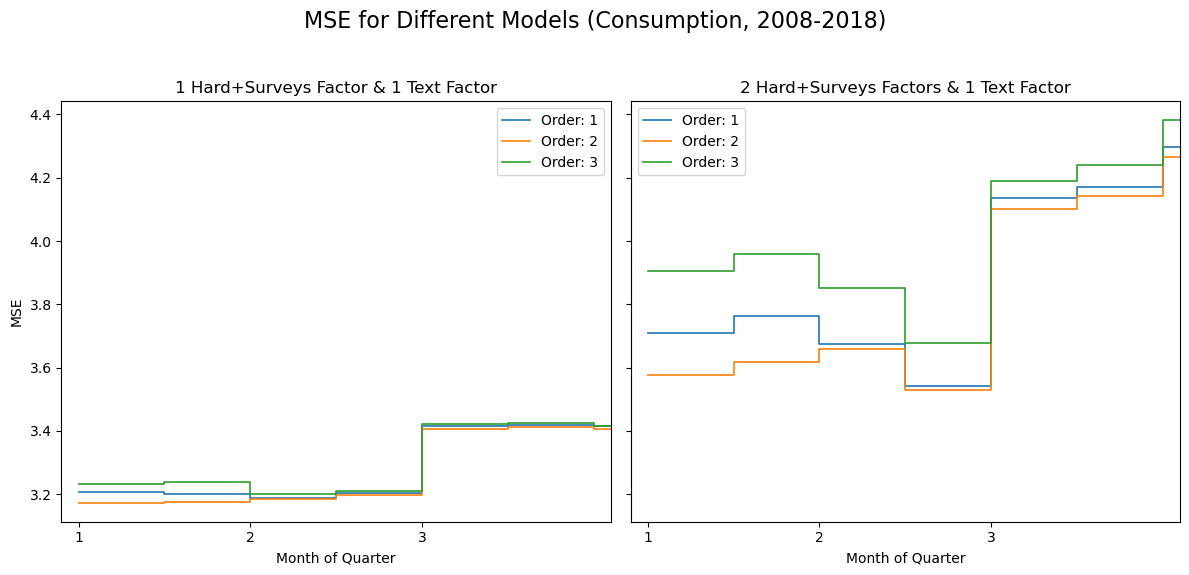

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Consumption'
text_type = "topics"
estimation_period = "2007"
num_topics = "200"
source = "all"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"

# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Loop over the number of HardSurveys factors (1 or 2)
for i, num_factors in enumerate(range(1, 3)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"HS_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


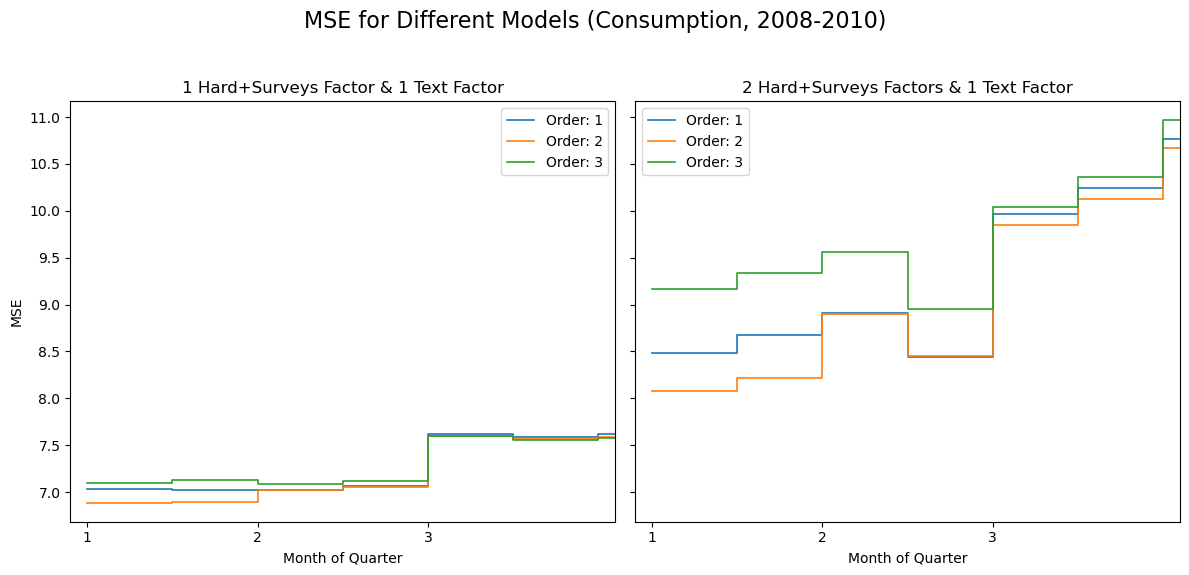

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


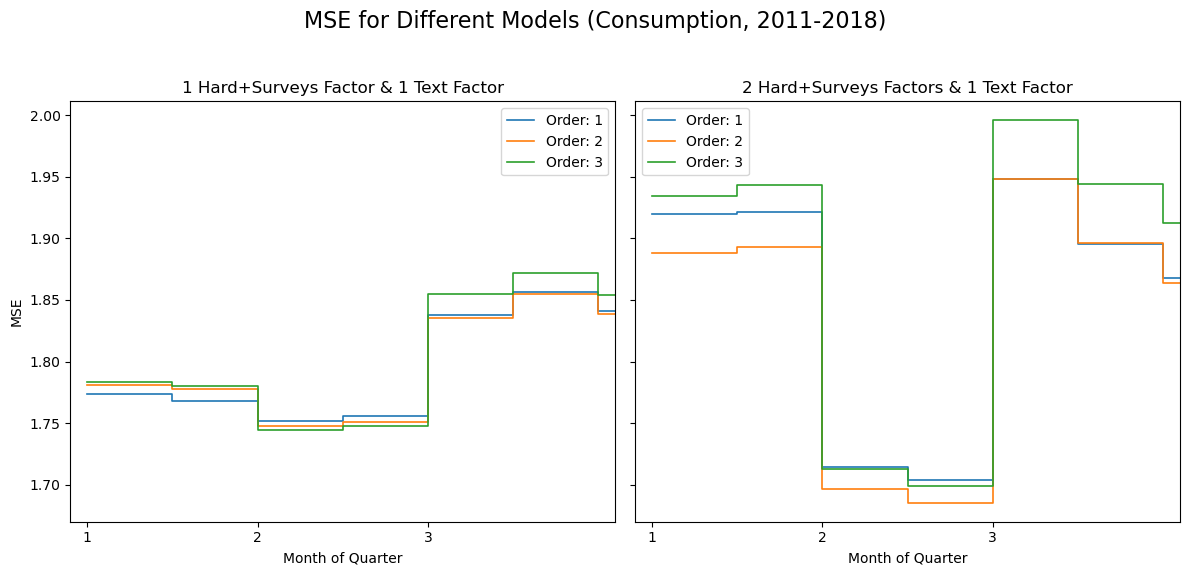

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 2 columns of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate(range(1, 3)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_Consumption_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


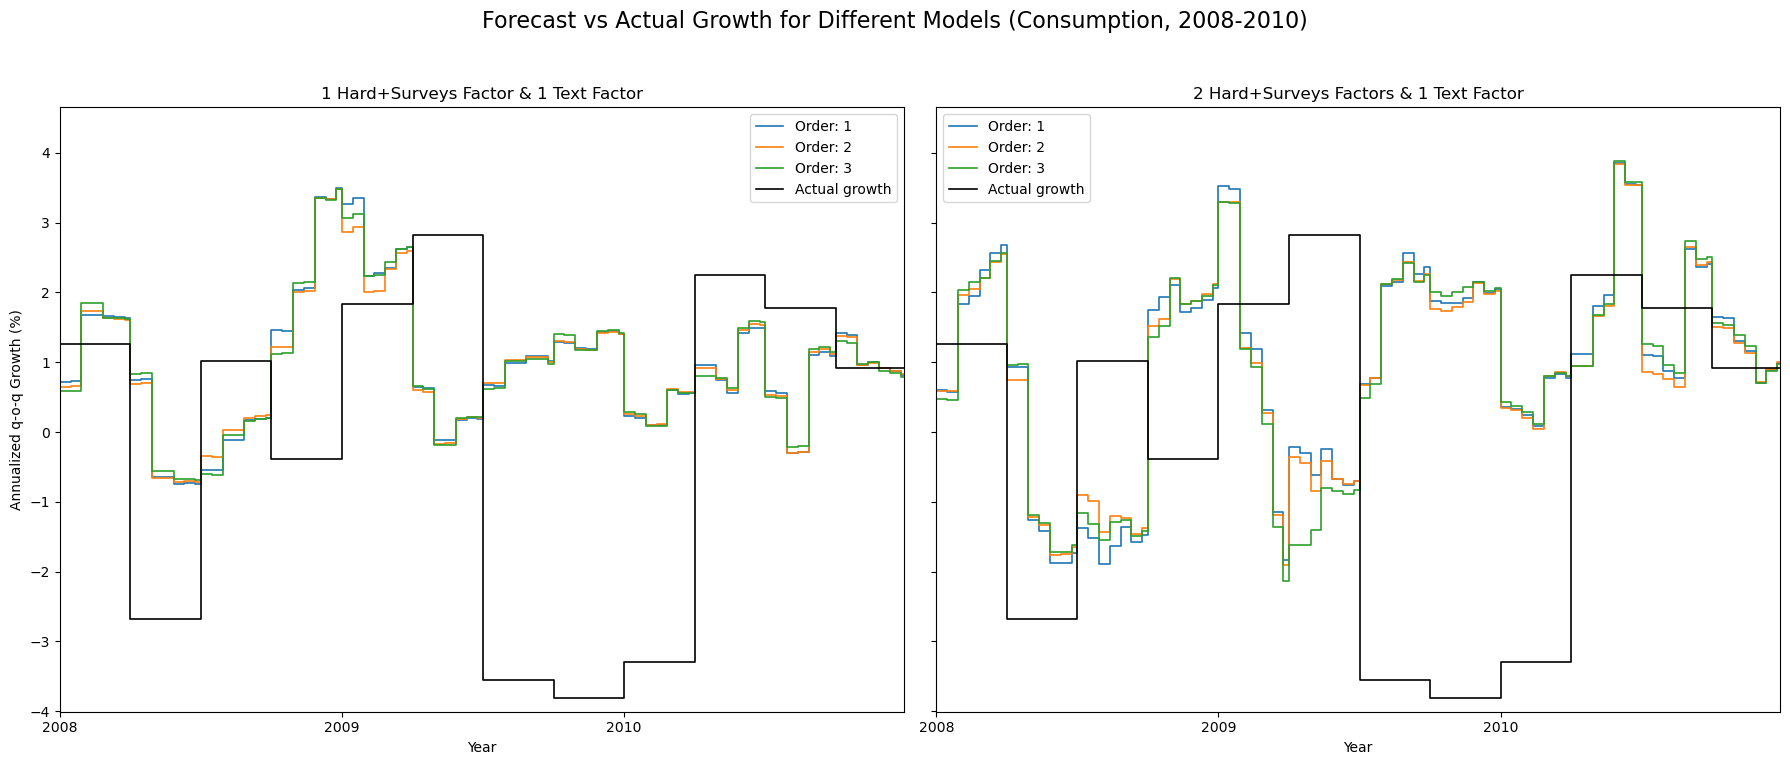

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


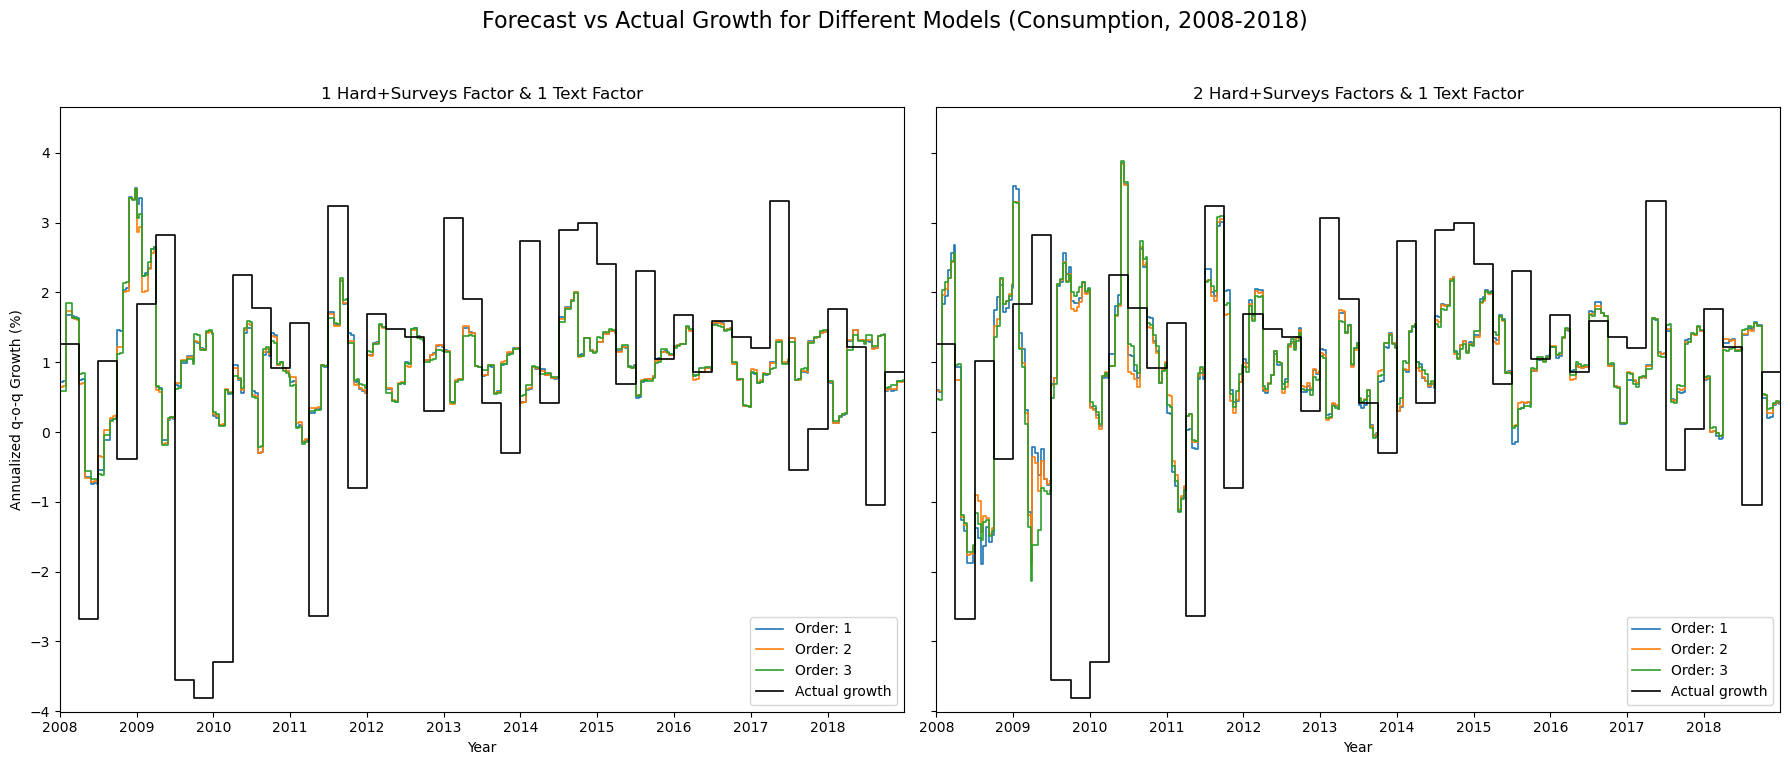

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


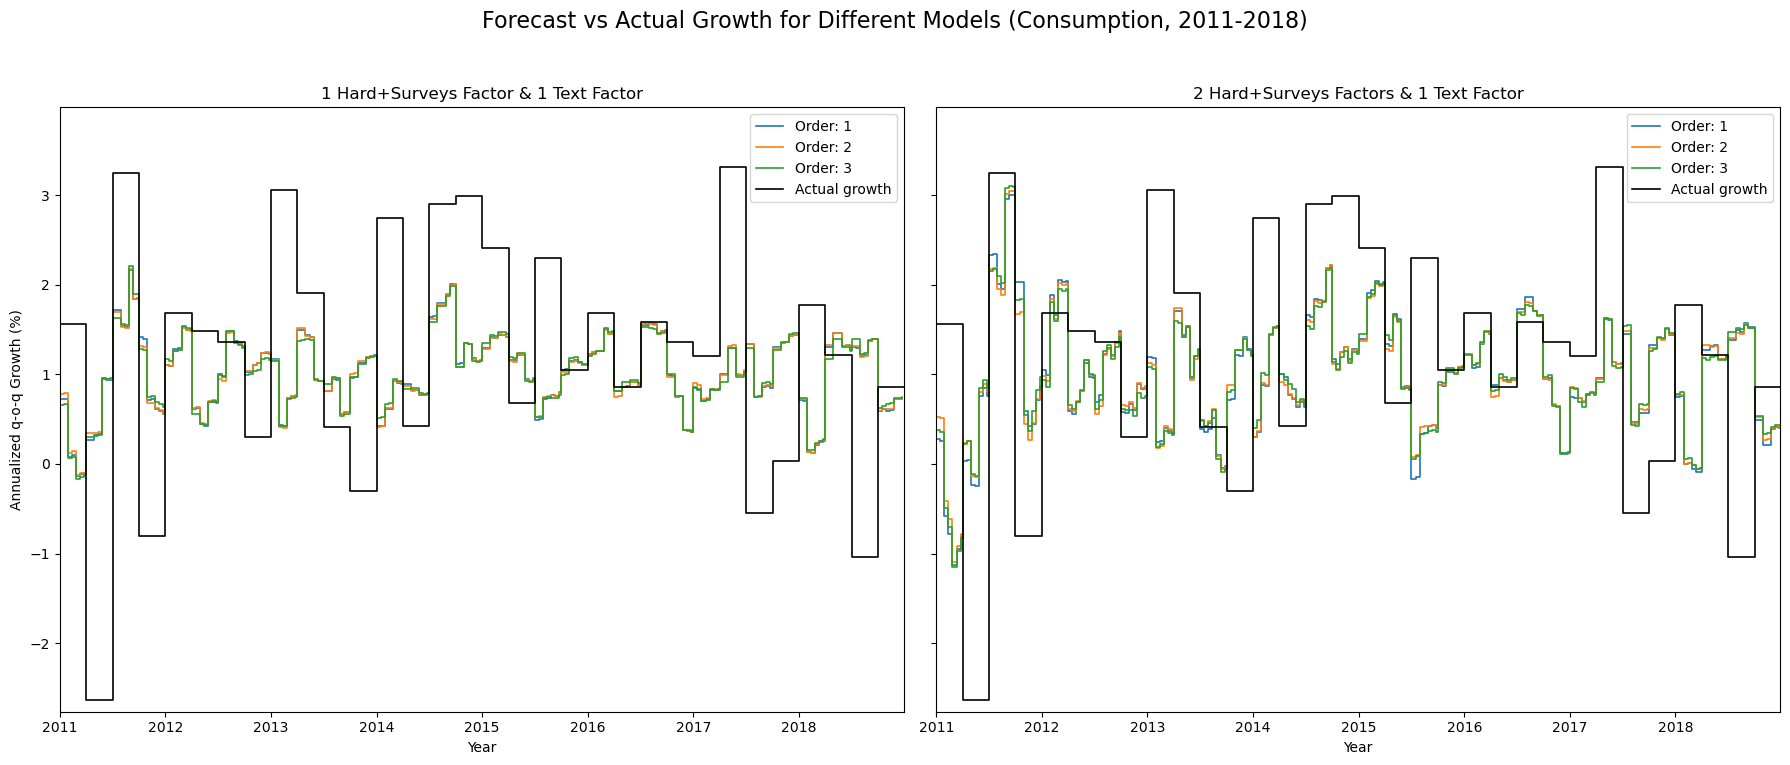

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 2 columns for the two Hard+Surveys factor counts
    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate([1, 2]):
        ax = axs[i]

        # For each HardSurveys factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_Consumption_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()